In [14]:
from __future__ import print_function, division

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from skimage import io
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [15]:
subset = 'train'
folder = ".."+os.sep+"data"+os.sep
file =  subset + os.sep + subset + ".csv"

#Create mapping for labels
df = pd.read_csv(folder + file)
classes = df.classid.unique()
classes.sort()
classes_map = { classes[i]:i for i in range(len(classes)) }

In [16]:
# Dataset Class
class PlantsDataset(Dataset):
    """Plants dataset."""

    def __init__(self, csv_file, root_dir, classes, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes_map = classes

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.df.iloc[idx, 1]))
        image = io.imread(img_name + '.jpg')
        label = self.df.iloc[idx, 4]
        sample = {'image': image, 'label': classes_map[label]}

        if self.transform:
            sample['image'] = Image.fromarray(sample['image'])
            sample['image'] = self.transform(sample['image'])

        return sample

In [17]:
# Load Data
resized = 'resized'
folder = ".."+os.sep+"data"+os.sep

transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

#Validation Data
subset = 'validation'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
valset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,shuffle=False, num_workers=0)

#Test Data
subset = 'test'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
testset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {"train" : list(), "val": list()}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data['image'].to(device), data['label'].to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            history[phase].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, data in enumerate(dataloaders['val']):
            inputs = data['image'].to(device)
            labels = data['label'].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, truth: {}'.format(preds[j],labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
def get_preds(net, loader):
    preds = list()
    with torch.no_grad():
        for data in testloader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.cpu().detach().numpy())
    return preds

In [22]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          dimensions=(32,24),
                          savepath=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=dimensions)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

In [23]:
def plot_history(history, savepath = None):
    plt.plot(history['train'])
    plt.plot(history['val'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    ticks = list(range(len(history['train'])))
    names = list(range(1,len(history['train'])+1))
    plt.xticks(ticks, names)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

### Deeper resnet with augmentation

In [24]:
resized = 'resized'
folder = ".."+os.sep+"data"+os.sep

transform_aug = transforms.Compose([
                    transforms.Resize(224),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform_aug)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

In [25]:
model_101_aug = models.resnet101(pretrained=True)
num_ftrs = model_101_aug.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_101_aug.fc = nn.Linear(num_ftrs, len(classes))

# Freeze all layers except last 2 residual blocks and output fc layer
for name, child in model_101_aug.named_children():
   if name in ['layer3','layer4','fc']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

model_101_aug = model_101_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_101_aug = optim.SGD(filter(lambda p: p.requires_grad, model_101_aug.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_101_aug, step_size=7, gamma=0.1)

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


In [26]:
model_101_aug, history = train_model(model_101_aug, criterion, optimizer_101_aug, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 2.6398 Acc: 0.3177
val Loss: 0.9492 Acc: 0.6849

Epoch 1/19
----------
train Loss: 1.2608 Acc: 0.6459
val Loss: 0.8211 Acc: 0.7669

Epoch 2/19
----------
train Loss: 0.8581 Acc: 0.7471
val Loss: 0.6901 Acc: 0.7914

Epoch 3/19
----------
train Loss: 0.6304 Acc: 0.8095
val Loss: 0.6969 Acc: 0.8259

Epoch 4/19
----------
train Loss: 0.4514 Acc: 0.8776
val Loss: 0.6959 Acc: 0.8331

Epoch 5/19
----------
train Loss: 0.3851 Acc: 0.8863
val Loss: 0.8904 Acc: 0.8201

Epoch 6/19
----------
train Loss: 0.2830 Acc: 0.9184
val Loss: 0.6866 Acc: 0.8446

Epoch 7/19
----------
train Loss: 0.1741 Acc: 0.9563
val Loss: 0.5619 Acc: 0.8791

Epoch 8/19
----------
train Loss: 0.1339 Acc: 0.9717
val Loss: 0.4979 Acc: 0.8849

Epoch 9/19
----------
train Loss: 0.1262 Acc: 0.9698
val Loss: 0.5176 Acc: 0.8835

Epoch 10/19
----------
train Loss: 0.1019 Acc: 0.9760
val Loss: 0.5908 Acc: 0.8806

Epoch 11/19
----------
train Loss: 0.1053 Acc: 0.9789
val Loss: 0.4847 Acc: 0.8906

Ep

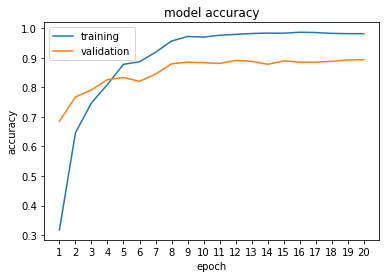

In [27]:
plot_history(history,'plots' + os.sep + 'model_101_aug_resize1.png')

In [28]:
y_predict = get_preds(model_101_aug, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.8820143884892087
Rappel: 0.8820143884892087
Precision: 0.8867107299813345
F-Measure: 0.8788430841626024


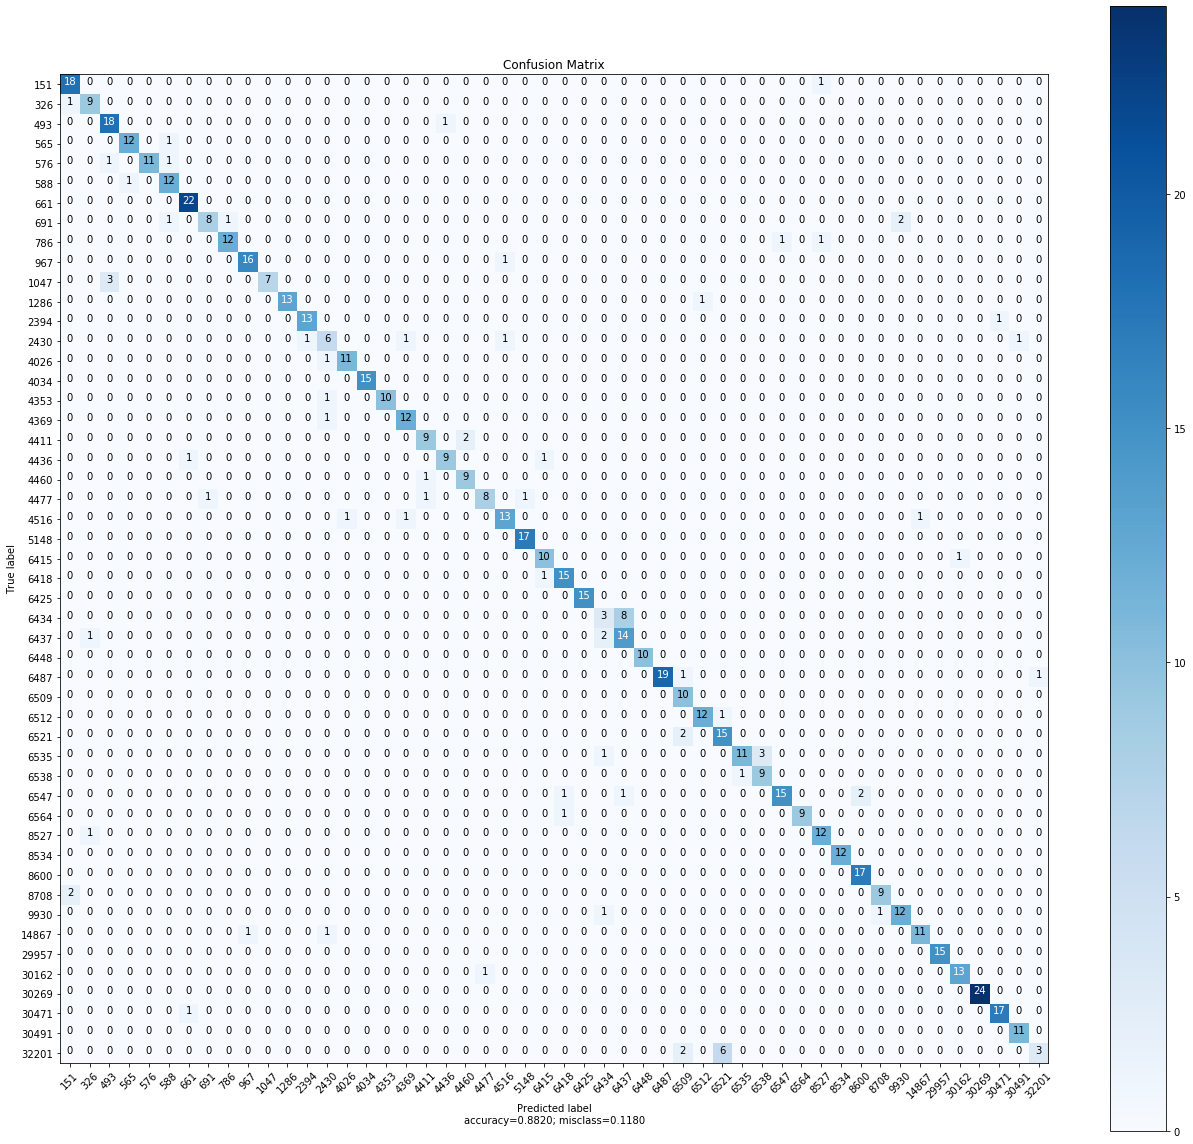

In [29]:
cm = confusion_matrix(y_true, y_predict)
plot_confusion_matrix(cm=cm,normalize=False,target_names=classes,
                      title="Confusion Matrix",savepath='plots' + os.sep + 'cm_model_101_aug_resize1.png',
                      dimensions=(18,16))

In [30]:
PATH = 'models' + os.sep + 'model_101_aug_resize1.pth'
torch.save(model_101_aug.state_dict(), PATH)